In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

In [3]:
# Load dataset
file_path = "balanced_intents.csv"
df = pd.read_csv(file_path)
print("Dataset Loaded Successfully!\n")

Dataset Loaded Successfully!



In [4]:
# Display dataset structure
print("Dataset Structure:\n", df.info(), "\n")
print("First 5 Rows:\n", df.head(), "\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1452 entries, 0 to 1451
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   intent                  1452 non-null   object
 1   response                1452 non-null   object
 2   intent_special_chars    1452 non-null   object
 3   response_special_chars  1452 non-null   object
dtypes: object(4)
memory usage: 45.5+ KB
Dataset Structure:
 None 

First 5 Rows:
                     intent                                           response  \
0        Headache Remedies    let me know which type of remedies do you want?   
1  heatwaves Symptom Check                         please check your symptoms   
2                 Headache    let me know which type of services do you want?   
3          Stress Remedies  Please let me know which type of remedies do y...   
4             Constipation       which services do you want for Constipation?   

  intent_spe

In [5]:
# Check for missing values
print("Missing Values:\n", df.isnull().sum(), "\n")

Missing Values:
 intent                    0
response                  0
intent_special_chars      0
response_special_chars    0
dtype: int64 



In [6]:
# Check unique intents
unique_intents = df['intent'].nunique()
print(f"Total Unique Intents: {unique_intents}\n")
print("Sample Intents:\n", df['intent'].value_counts().head(), "\n")

Total Unique Intents: 121

Sample Intents:
 intent
Headache Remedies        12
Cold Symptom Check       12
Welocme Intent           12
Constipation Remedies    12
Other illeness Fits      12
Name: count, dtype: int64 



In [7]:
# Function to clean text
def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)  # Remove punctuation
    text = re.sub("\d+", "", text)  # Remove numbers
    text = re.sub("\s+", " ", text).strip()  # Remove extra spaces
    return text

# Apply text cleaning
df['cleaned_response'] = df['response'].apply(clean_text)
print("Text Cleaning Examples:\n", df[['response', 'cleaned_response']].head(), "\n")

Text Cleaning Examples:
                                             response  \
0    let me know which type of remedies do you want?   
1                         please check your symptoms   
2    let me know which type of services do you want?   
3  Please let me know which type of remedies do y...   
4       which services do you want for Constipation?   

                                    cleaned_response  
0     let me know which type of remedies do you want  
1                         please check your symptoms  
2     let me know which type of services do you want  
3  please let me know which type of remedies do y...  
4        which services do you want for constipation   



In [8]:
# Splitting dataset
X = df['cleaned_response']
y = df['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(f"Training Data: {X_train.shape}, Testing Data: {X_test.shape}\n")

Training Data: (1161,), Testing Data: (291,)



In [9]:
# Vectorizing text
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
print("TF-IDF Vectorization Complete!\n")

TF-IDF Vectorization Complete!



In [10]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Naive Bayes": MultinomialNB(),
    "Support Vector Machine": SVC(kernel='linear', probability=True)
}

In [11]:
# Train and evaluate models
for name, model in models.items():
    print(f"Training {name}...\n")
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
    print(f"Classification Report for {name}:\n{classification_report(y_test, y_pred)}\n")
    print("="*80, "\n")

print("All models trained and evaluated successfully!")

Training Logistic Regression...

Logistic Regression Accuracy: 0.9416

Classification Report for Logistic Regression:
                                   precision    recall  f1-score   support

                               BP       1.00      1.00      1.00         2
            BP Ayurvedic Remedies       1.00      1.00      1.00         3
                          BP Diet       1.00      1.00      1.00         3
                 BP Home Remedies       1.00      1.00      1.00         2
          BP Naturopathy Remedies       1.00      1.00      1.00         2
                    BP medication       1.00      1.00      1.00         2
                      BP remedies       1.00      1.00      1.00         3
                 BP symptom check       1.00      1.00      1.00         2
                          BP yoga       1.00      1.00      1.00         2
                             Cold       1.00      1.00      1.00         2
                   Cold  Remedies       0.33      1.00  

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from itertools import cycle

In [22]:
# Get top 4 classes
top_classes = df['intent'].value_counts().head(4).index.tolist()
top_class_indices = [np.where(np.unique(y_test) == cls)[0][0] for cls in top_classes]

# Function to plot ROC for top classes
def plot_top_classes_roc(model, X_test, y_test, classes, class_indices, model_name, ax=None):
    # Binarize the output
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    
    # Get predicted probabilities
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    else:  # For SVM without probability
        y_score = model.decision_function(X_test)
        y_score = np.exp(y_score) / np.sum(np.exp(y_score), axis=1, keepdims=True)
    
    # Compute ROC curve and ROC area for each top class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i, cls_idx in enumerate(class_indices):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, cls_idx], y_score[:, cls_idx])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    if ax is None:
        plt.figure(figsize=(8, 6))
        ax = plt.gca()
    
    colors = cycle(['blue', 'red', 'green', 'orange'])
    for i, color, cls in zip(range(len(class_indices)), colors, classes):
        ax.plot(fpr[i], tpr[i], color=color, lw=2,
                label='{0} (AUC = {1:0.2f})'
                ''.format(cls[:25] + '...' if len(cls) > 25 else cls, roc_auc[i]))
    
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title(f'ROC Curve - {model_name}', fontsize=14)
    ax.legend(loc="lower right", fontsize=10)
    
    return roc_auc



COMPREHENSIVE MODEL COMPARISON


,Accuracy,Precision (macro),Recall (macro),F1-score (macro),ROC AUC (micro),AUC (Headache Remedi...),AUC (Cold Symptom Ch...),AUC (Welocme Intent...),AUC (Constipation Re...)
Model,,,,,,,,,
Logistic Regression,0.942,0.933,0.945,0.933,1.000,0.993,1.000,1.000,0.993
Random Forest,0.942,0.933,0.945,0.933,1.000,0.993,1.000,1.000,0.993
Naive Bayes,0.931,0.924,0.937,0.923,0.999,0.993,1.000,1.000,0.993
Support Vector Machine,0.931,0.924,0.937,0.923,1.000,0.993,1.000,1.000,0.993


<Figure size 1500x1000 with 0 Axes>

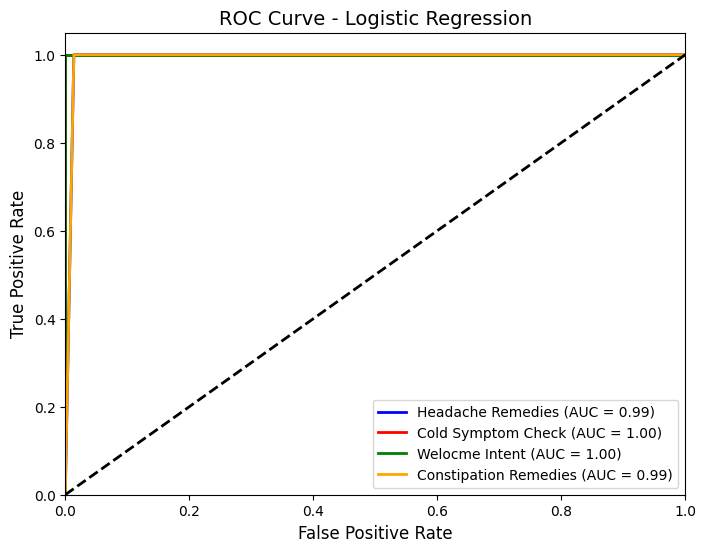

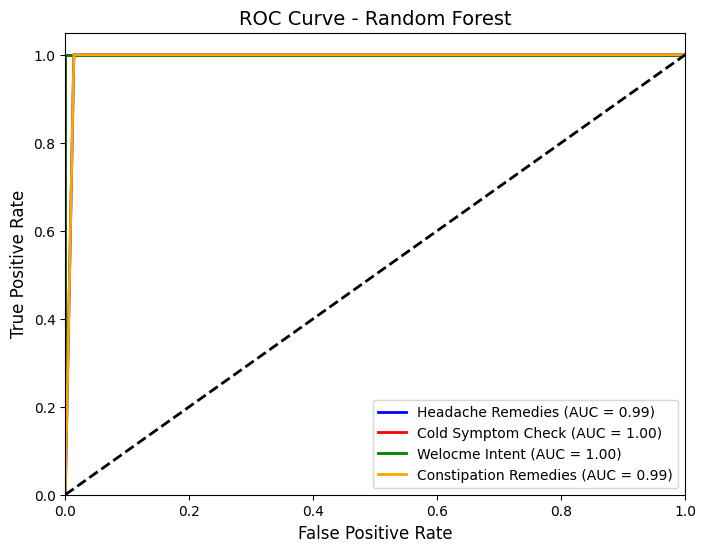

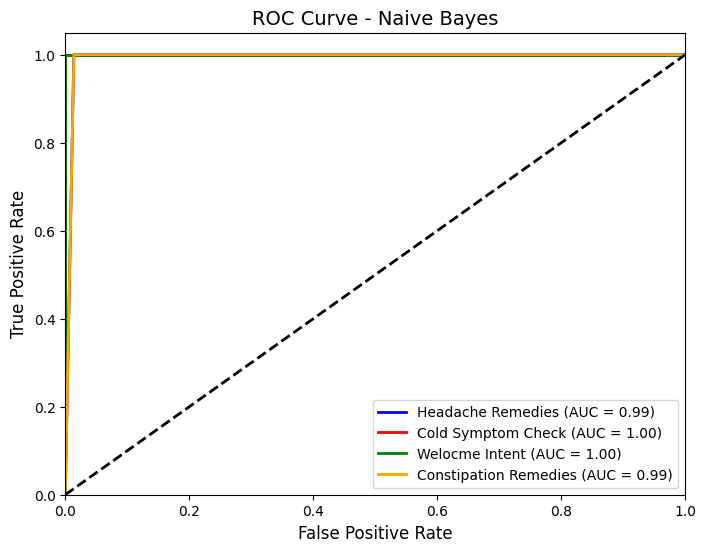

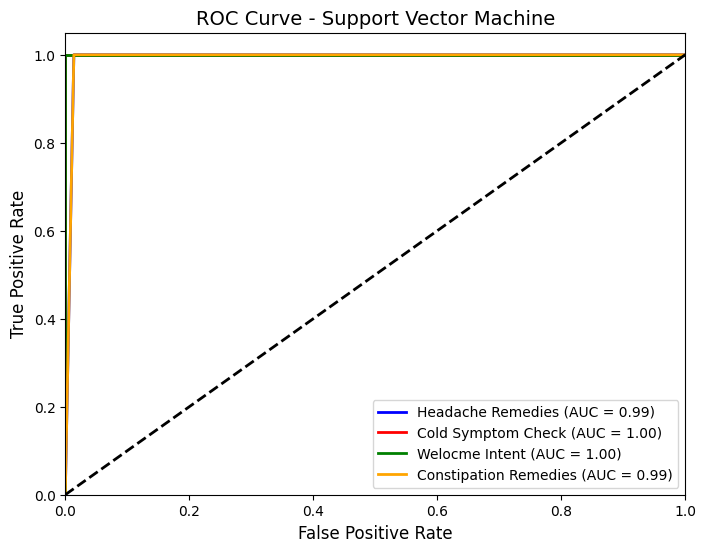

<Figure size 1500x1000 with 0 Axes>

In [23]:
# Create comprehensive metrics dataframe
metrics_list = []

for name, model in models.items():
    # Get predictions
    y_pred = model.predict(X_test_tfidf)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Calculate ROC AUC for top classes
    roc_auc = plot_top_classes_roc(model, X_test_tfidf, y_test, top_classes, top_class_indices, name)
    
    # Store metrics
    metrics = {
        'Model': name,
        'Accuracy': accuracy,
        'Precision (macro)': report['macro avg']['precision'],
        'Recall (macro)': report['macro avg']['recall'],
        'F1-score (macro)': report['macro avg']['f1-score'],
        'ROC AUC (micro)': roc_auc['micro']
    }
    
    # Add AUC for top classes
    for i, cls in enumerate(top_classes):
        metrics[f'AUC ({cls[:15]}...)'] = roc_auc[i]  # Truncate long class names
    
    metrics_list.append(metrics)

# Create comparison dataframe
comparison_df = pd.DataFrame(metrics_list)

# Set Model as index for display
display_df = comparison_df.set_index('Model')

# Display metrics table with formatting
print("\nCOMPREHENSIVE MODEL COMPARISON")
print("="*50)
display(display_df.style
        .background_gradient(cmap='Blues', subset=['Accuracy', 'ROC AUC (micro)'])
        .background_gradient(cmap='Greens', subset=['Precision (macro)', 'Recall (macro)', 'F1-score (macro)'])
        .format("{:.3f}"))

# Visualizations
plt.figure(figsize=(15, 10))

(0.8, 1.0)

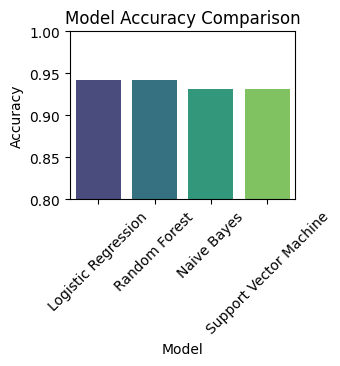

In [24]:
# 1. Main metrics comparison
plt.subplot(2, 2, 1)
sns.barplot(data=comparison_df, x='Model', y='Accuracy', palette='viridis')
plt.title('Model Accuracy Comparison', fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0.8, 1.0)  # Adjusted ylim to better show differences

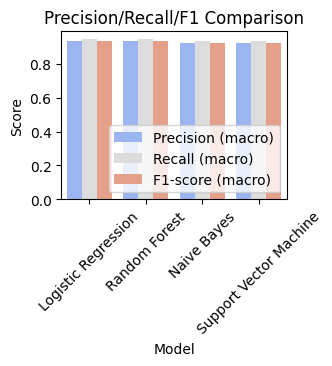

In [25]:
# 2. Precision/Recall/F1 comparison
plt.subplot(2, 2, 2)
melted_df = comparison_df.melt(id_vars=['Model'], 
                              value_vars=['Precision (macro)', 'Recall (macro)', 'F1-score (macro)'],
                              var_name='Metric', value_name='Score')
sns.barplot(data=melted_df, x='Model', y='Score', hue='Metric', palette='coolwarm')
plt.title('Precision/Recall/F1 Comparison', fontsize=12)
plt.xticks(rotation=45)
plt.legend(loc='lower right')

(0.8, 1.0)

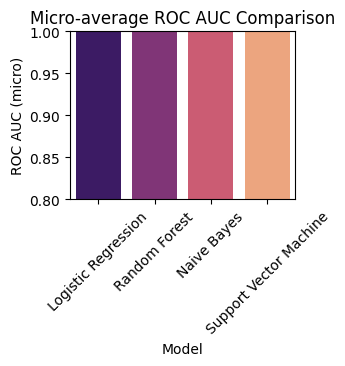

In [26]:
# 3. ROC AUC comparison
plt.subplot(2, 2, 3)
sns.barplot(data=comparison_df, x='Model', y='ROC AUC (micro)', palette='magma')
plt.title('Micro-average ROC AUC Comparison', fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0.8, 1.0)  # Adjusted ylim to better show differences

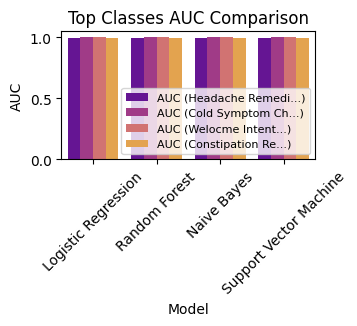

In [27]:
# 4. Top classes AUC comparison
plt.subplot(2, 2, 4)
top_auc_cols = [col for col in comparison_df.columns if col.startswith('AUC (')]
top_auc_df = comparison_df.melt(id_vars=['Model'], 
                              value_vars=top_auc_cols,
                              var_name='Class', value_name='AUC')
sns.barplot(data=top_auc_df, x='Model', y='AUC', hue='Class', palette='plasma')
plt.title('Top Classes AUC Comparison', fontsize=12)
plt.xticks(rotation=45)
plt.legend(loc='lower right', fontsize=8)  # Smaller font for legend

plt.tight_layout()
plt.show()

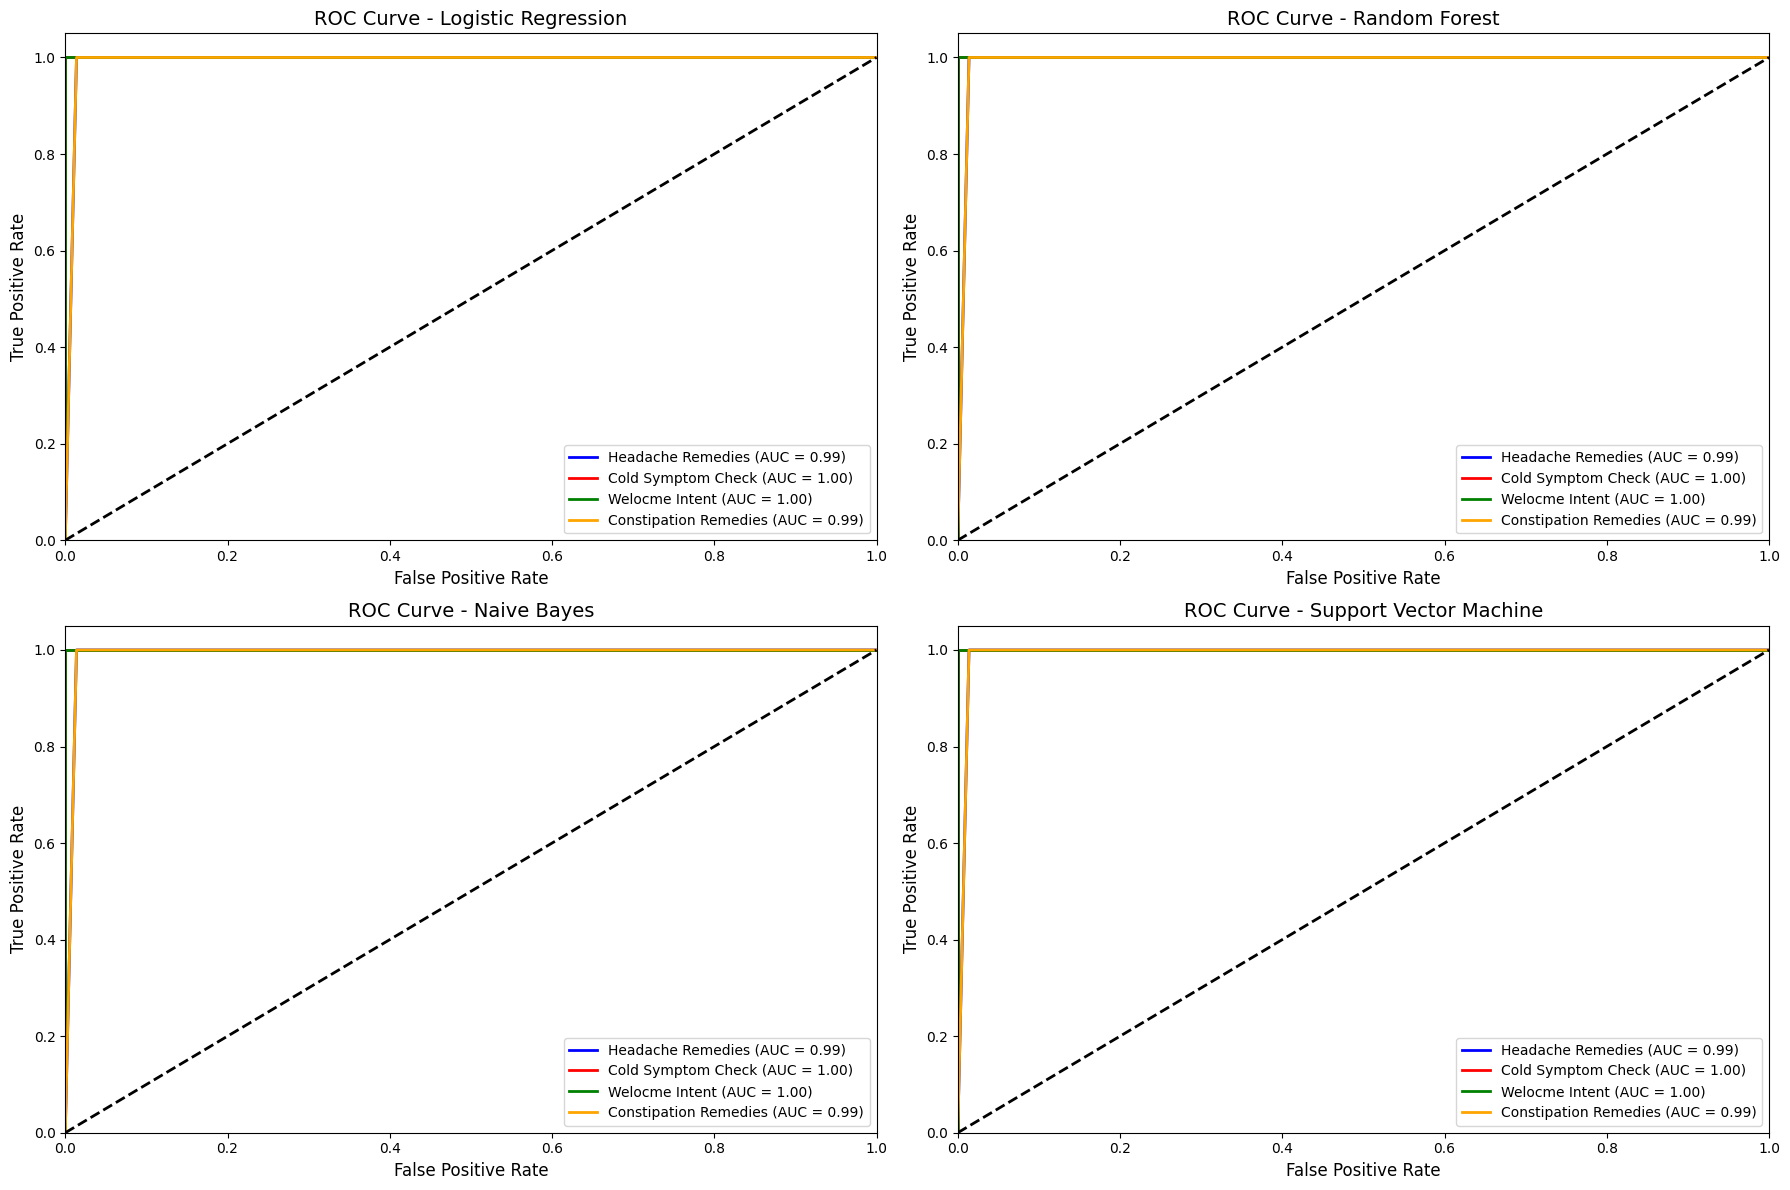

In [28]:
# Plot ROC curves for all models in a grid
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.ravel()

for (name, model), ax in zip(models.items(), axes):
    plot_top_classes_roc(model, X_test_tfidf, y_test, top_classes, top_class_indices, name, ax=ax)

plt.tight_layout()
plt.show()